# Nurse scheduling problem 

## Implementing linear programming  algorithm to solve the NP-hard nurse scheduling problem. 


### Some basic constraints and assumptions:

* Each day is divided into 2 separate shifts of 12 hours (day/night).

* There are a number of required nurses for each of them. 

* A nurse is off on a specific day if no shift is assigned or if the nurse has requested a PTO on that specific day. 

* The planning length is 4 weeks (28 days). 
    
    * In this notebook, used 1 week instead for the purpose of convenience and easy visualization.

* Each nurse should work either 12, 24 or 36 hours hours per week.


### I personally add few more constraints:

* No nurse will work on both shifts in the single day.

* A nurse who works on a nigth shift will take the next day off.

* Max numbers of night shift for each nurse is at most ONE.

In [2]:
import pandas as pd
import numpy as np
import scipy as sp
import seaborn as sns
import matplotlib.pyplot as plt
from pandas.tools.plotting import table
import os, sys, json
from pulp import *

%matplotlib inline

In [92]:
class nurse:

	"""
	nurse class for the scheduling problem
	"""

	def __init__(self, nurse_max_shifts = 3, planning_length = 1, daily_shift = 2, 
		nurse_per_shift = None, total_nurses = None):

		# nurse works either 12, 24, 36 hours per week.
		self.nurse_working_shift = range(1, nurse_max_shifts + 1) 
		self.nurse_max_shifts = nurse_max_shifts

		# planning_length: 1 week, 2 week or 4 weeks
		self.n = planning_length

		# numbers of shift per day
		# for example: 
		# [day, night] = [0, 1]
		self.daily_shift = range(daily_shift)

		# label each day from Monday to Sunday:
		self.day = ['M', 'Tu', 'W', 'Th', 'F','Sa','Su']
		self.shift_name = []
		for w in range(1, self.n+1):
			for d in self.day:
				for i in self.daily_shift:
					self.shift_name.append('week'+str(w)+'_'+str(d)+'_'+str(i))

		"""
		Create the require_nurses for all the shifts.
		Basically, the length of shift list is:
		len(shifts) = daily_shift * 7 * planning_length
		
		for example: if daily_shift is 2 (day/night), planning_length is 1
		shifts[0] = First week Monday day shift
		shifts[1] = First week Monday night shift
		shifts[2] = First week Tuesday day shift
		...
		shifts[-1] = Last week Sunday night shift

		"""
		self.shifts = range(daily_shift * 7 * planning_length)
		
		"""
		required nurses for shifts are:
		randomly generated value if not provided (for demo purpose)
		
		for example, day shift needs 5 nurses each day, night shift needs 3 nurses
		the corresponding required nurses will be:
		[5, 3, 5, 3, 5, 3, 5, 3, 5, 3, 5, 3, 5, 3]
		"""
		if not nurse_per_shift:
			self.nurse_per_shift = [5, 3]
		else:
			self.nurse_per_shift = nurse_per_shift

		self.r = self.nurse_per_shift * 7 * planning_length


		# total nurses working in the hospital
		if not total_nurses:
			self.total_nurses = int(sum(self.r)/1)
		else:
			self.total_nurses = total_nurses

		# create nurses list and nurses_id tag:
		# nurses: label each nurse. Simply use integers to represent.
		self.nurses = range(self.total_nurses)
		self.nurses_id = ['nurse'+str(i) for i in range(self.total_nurses)]


		"""
		create a off_shift dictionary for the nurses who requested PTO or
		have a shift off.
		"""
		self.off_shift = {}

		# initialize a linear programming problem
		self.prob = LpProblem("Nurse scheduling",LpMinimize)

	
	def update_off_shift(self, fileName = 'utils/off_shift.json'):

		'''
		Update the off_shift in the json file.
		'''

		try:
			with open(fileName, 'r') as fp:
				self.off_shift = json.load(fp)
		except IOError:
			print "The file path does not exist"
			sys.exit(-1)


	def lp_problem(self):

	    '''
	    Use pulp to solve the constrained problem using linear programming(LP) algorithm. 
	    1. Create LpVariables. Binary category in this case
	    2. Add constraints in either equality or inequality conditions.
	    3. Building objective using LpObjective. 
	    '''
	    
	    # Creating the variables. 
	    self.var = {
	     (n, s): LpVariable(
	        "schdule_{0}_{1}".format(n, s), cat = "Binary")
	        for n in self.nurses for s in self.shifts
	    }

	    
	    # add constraints: 
	    # Nurses do not work in two consecutive shifts
	    # If nurse works for a night shift, he/she will take a next day off

	    for n in self.nurses:
	        for s in self.shifts:
	            if s%2 == 0:
	                self.prob.addConstraint(
	                self.var[(n,s)] + self.var[(n, s+1)] <= 1  # for day shift
	               )
	            elif s%2 == 1 and s < self.shifts[-1]:
	                # night shift. Do not forget to add condition that the last
	                # shift in the scheduling does not count.
	                self.prob.addConstraint(
	                self.var[(n, s)] + self.var[(n, s+1)] + self.var[(n, s+2)] <= 1
	                )

	    # add constraints:
	    # Request PTO or take a specific day off:
	    for n in self.nurses:
	        if n in self.off_shift:
	            for s in self.off_shift[n]:
	                self.prob.addConstraint(
	                self.var[(n, s)] == 0
	                )

	    # add constraints:
	    # Working shift is either 1, 2 or 3
	    # Here the first calculation is based on 
	    for n in self.nurses:
	        self.prob.addConstraint(
	        sum(self.var[(n,s)] for s in self.shifts) <= self.nurse_max_shifts    
	        )
	        self.prob.addConstraint(
	        sum(self.var[(n,s)] for s in self.shifts) >= 1
	        )

	    # add constraints
	    # Max numbers of night shift is one for each nurse

	    for n in self.nurses:
	        self.prob.addConstraint(
	        sum(self.var[(n, s)] for s in self.shifts if s%2) <= 1
	        )
	    # add constraints
	    # for each shift, the numbers of working nurses should be greater than
	    # the required numbers of nurses
	    for s in self.shifts:
	        try:
	            self.prob.addConstraint(
	            sum(self.var[(n,s)] for n in self.nurses) >= self.r[s]
	            )
	        except:
	            print "len(shifts) should be equal to len(require_nurses)"
	            sys.exit(-1)   

	            
	    # add objective: minimize the numbers of total nurses required
	    # nurse_working = []
	    # for s in shifts:
	    #     nurse_shift = sum(var[(n, s)] for n in nurses)
	    #     nurse_working.append(
	    #     pulp.LpVariable("nurses_%d"%(s,), cat = 'Integer', lowBound = 0)
	    #     )
	    self.prob.objective = sum(self.var[(n,s)] for n in self.nurses for s in self.shifts)   
	    

	def lp_solve(self, solver = None):

		# problem solver

		# if solver:
		# 	self.prob.solve(solver)
		# else:
		# 	self.prob.solve()
		self.prob.solve()


		print "The status of solving the problem is: "
		print LpStatus[self.prob.status]


	def nurse_scheduling(self):

		# output the whole scheduling

		self.sch = pd.DataFrame(data=None, index = self.nurses_id, columns = self.shift_name) 
		for k, v in self.var.items():
			n, s = k[0], k[1]
			self.sch.iloc[n][s] = int(value(v))

		return self.sch


	def schedule_which_nurse(self, nurseWho = 0):
	    
	    '''
	    nurseWho: nurse id
	    table: Either the schedule dataframe or the linear programming solution
	    inputType: if 'lp': use linear programming solution
	               else: the dataframe
	    '''
	    # Get the data for scheduling nurse n:
	    res = []
	       
	    for s in self.shifts:
	        res.append(
	            int(value(self.var[(nurseWho, s)]))
	            )
	    
	    num_shift = len(self.daily_shift)
	    res = np.array(res).reshape(len(res)/num_shift, num_shift).swapaxes(0, 1)
	    
	    col = ['week'+str(w) + '_' + str(d) for w in range(1, self.n + 1) for d in self.day]
	    df_sch = pd.DataFrame(res, index = self.daily_shift, columns = col)
	    
	    return df_sch



def plot_table(df, figSize = (4,2), saveFig = False, figTitle = 'nurse_scheduling'):
     
    # visulize the schedule  
    colors = df.applymap(lambda x: 'lightgray' if x== 0 else 'lightcoral') 

    fig = plt.figure(figsize=figSize)

    ax = plt.subplot(2, 1, 1, frame_on = True)  # no visible frame
    #ax.xaxis.set_visible(False)  # hide the x axis
    #ax.yaxis.set_visible(False)
    ax.axis('off')

    tb1 = table(ax,df,
                loc='center',
                cellLoc='center',
                cellColours=colors.as_matrix(),
                fontsize=14
          )

    if saveFig == True:
        if not os.path.isdir('figs/'):
            os.mkdir('figs/')
        plt.savefig('figs/'+ figTitle +'.png', bbox_inches='tight', dpi = 150)

    # refresh the plot
    plt.show()


def main():

	model = nurse()

	model.update_off_shift()

	model.lp_problem()

	model.lp_solve()

	schedule = model.nurse_scheduling()

	print schedule.head(5)

	print "The schedule of all nurses: "
	plot_table(schedule, figSize = (10, 4), saveFig = True)

	for n in model.nurses[:3]:
		print 'The schedule of nurses' + str(n)
        df = model.schedule_which_nurse(n)
        print df
    	plot_table(df, saveFig = True, figTitle = 'nurse' + str(n))

The status of solving the problem is: 
Optimal
       week1_M_0 week1_M_1 week1_Tu_0 week1_Tu_1 week1_W_0 week1_W_1  \
nurse0         0         1          0          0         0         0   
nurse1         0         0          0          0         0         0   
nurse2         0         0          1          0         0         0   
nurse3         0         0          0          0         0         0   
nurse4         0         0          1          0         0         0   

       week1_Th_0 week1_Th_1 week1_F_0 week1_F_1 week1_Sa_0 week1_Sa_1  \
nurse0          0          0         0         0          0          0   
nurse1          0          0         0         1          0          0   
nurse2          0          0         0         0          0          0   
nurse3          0          1         0         0          0          0   
nurse4          0          0         0         0          0          0   

       week1_Su_0 week1_Su_1  
nurse0          0          0  
nurse1       

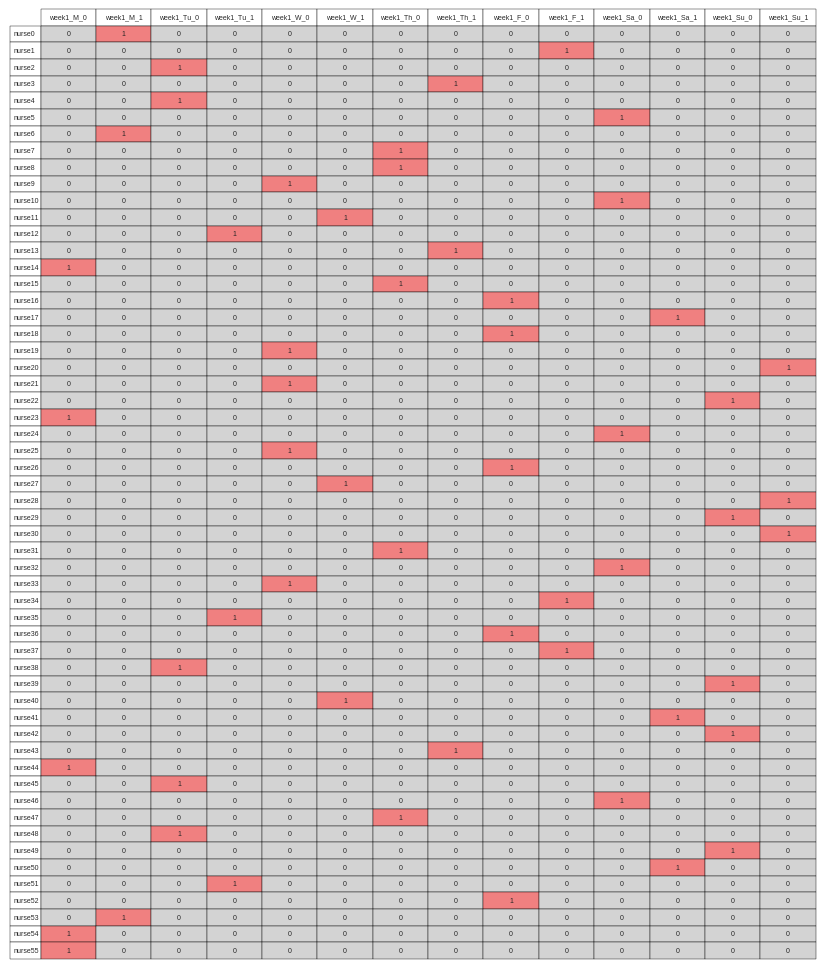

The schedule of nurses0
The schedule of nurses1
The schedule of nurses2
   week1_M  week1_Tu  week1_W  week1_Th  week1_F  week1_Sa  week1_Su
0        0         1        0         0        0         0         0
1        0         0        0         0        0         0         0


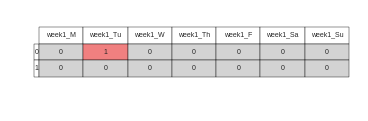

In [87]:
main()

In [94]:
for n in model.nurses[:3]:
    print 'The schedule of nurses' + str(n)
    df = model.schedule_which_nurse(n)
    print df
    plot_table(df, saveFig = True, figTitle = 'nurse' + str(n))

The schedule of nurses0


UnboundLocalError: local variable 'sch' referenced before assignment

In [95]:
5%3

2

In [100]:
class nurse:

	"""
	nurse class for the scheduling problem
	"""

	def __init__(self, daily_shift = 3, nurse_max_shifts = 5, planning_length = 4,  
		nurse_per_shift = [5, 4, 3], total_nurses = None):

		# nurse works either 12, 24, 36 hours per week.
		self.nurse_working_shift = range(1, nurse_max_shifts + 1) 
		self.nurse_max_shifts = nurse_max_shifts

		# planning_length: 1 week, 2 week or 4 weeks
		self.n = planning_length

		# numbers of shift per day
		# for example: 
		# [day, night] = [0, 1]
		self.daily_shift = range(daily_shift)
		self.daily_shift_n = daily_shift

		# label each day from Monday to Sunday:
		self.day = ['M', 'Tu', 'W', 'Th', 'F','Sa','Su']
		self.shift_name = []
		for w in range(1, self.n+1):
			for d in self.day:
				for i in self.daily_shift:
					self.shift_name.append('w'+str(w)+'_'+str(d)+'_'+str(i))

		"""
		Create the require_nurses for all the shifts.
		Basically, the length of shift list is:
		len(shifts) = daily_shift * 7 * planning_length
		
		for example: if daily_shift is 2 (day/night), planning_length is 1
		shifts[0] = First week Monday day shift
		shifts[1] = First week Monday night shift
		shifts[2] = First week Tuesday day shift
		...
		shifts[-1] = Last week Sunday night shift

		"""
		self.shifts = range(daily_shift * 7 * planning_length)
		
		"""
		required nurses for shifts are:
		randomly generated value if not provided (for demo purpose)
		
		for example, day shift needs 5 nurses each day, night shift needs 3 nurses
		the corresponding required nurses will be:
		[5, 4, 3, ...., 5, 4, 3]
		"""
		if not nurse_per_shift:
			self.nurse_per_shift = [5, 4, 3]
		else:
			self.nurse_per_shift = nurse_per_shift

		self.r = self.nurse_per_shift * 7 * self.n


		# total nurses working in the hospital
		if not total_nurses:
			self.total_nurses = int(sum(self.r)/(self.nurse_max_shifts - 1)/self.n)
		else:
			self.total_nurses = total_nurses

		# create nurses list and nurses_id tag:
		# nurses: label each nurse. Simply use integers to represent.
		self.nurses = range(self.total_nurses)
		self.nurses_id = ['nurse'+str(i) for i in range(self.total_nurses)]


		"""
		create a off_shift dictionary for the nurses who requested PTO or
		have a shift off.
		"""
		self.off_shift = {}

		# initialize a linear programming problem
		self.prob = LpProblem("Nurse scheduling",LpMinimize)

	
	def update_off_shift(self, fileName = 'utils/off_shift.json'):

		'''
		Update the off_shift in the json file.
		'''

		try:
			with open(fileName, 'r') as fp:
				self.off_shift = json.load(fp)
		except IOError:
			print "The file path does not exist"
			sys.exit(-1)

		print self.off_shift


	def lp_problem(self):

	    '''
	    Use pulp to solve the constrained problem using linear programming(LP) algorithm. 
	    1. Create LpVariables. Binary category in this case
	    2. Add constraints in either equality or inequality conditions.
	    3. Building objective using LpObjective. 
	    '''
	    
	    # Creating the variables. 
	    self.var = {
	     (n, s): LpVariable(
	        "schdule_{0}_{1}".format(n, s), cat = "Binary")
	        for n in self.nurses for s in self.shifts
	    }

	    
	    # add constraints: 
	    # Nurses do not work in two consecutive shifts in a signle day
	    # If nurse works for a night shift, he/she will take a next day off

	    for n in self.nurses:
	        for s in self.shifts:
	            if s%self.daily_shift_n == 0:
	                self.prob.addConstraint(
	                sum(self.var[(n,s+i)] for i in self.daily_shift) <= 1  # for day shift
	               )
	            elif (s+1)%self.daily_shift_n == 0 and s < self.shifts[-1]:  # for late night shift
	                # night shift. Do not forget to add condition that the last
	                # shift in the scheduling does not count.
	                self.prob.addConstraint(
	                sum(self.var[(n, s+i)] for i in range(self.daily_shift_n+1)) <= 1
	                )

	    # add constraints:
	    # Request PTO or take a specific day off:

	    for n in self.nurses:
	        if str(n) in self.off_shift:
	            for s in self.off_shift[str(n)]:
	                self.prob.addConstraint(
	                self.var[(n, s)] == 0
	                )

	    # add constraints:
	    # Working shift is in range(nurse_max_shifts). 

	    for n in self.nurses:
	    	for i in range(self.n): 
	    		begin, end = 7*self.daily_shift_n*i, 7*self.daily_shift_n*(i+1)
	    	# each week: the nurse cannot work over 5 shifts.
		        self.prob.addConstraint(
		        sum(self.var[(n,s)] for s in self.shifts[begin:end]) <= self.nurse_max_shifts    
		        )
		        self.prob.addConstraint(
		        sum(self.var[(n,s)] for s in self.shifts[begin:end]) >= 1 
		        )

	    # add constraints
	    # Max numbers of night shift is one for each nurse per week.

	    for n in self.nurses:
	    	for i in range(self.n):
	    		begin, end = 7*self.daily_shift_n*i, 7*self.daily_shift_n*(i+1)
		        self.prob.addConstraint(
		        sum(self.var[(n, s)] for s in self.shifts[begin:end] if (s+1)%self.daily_shift_n == 0) <= 1
		        )

	    # add constraints
	    # for each shift, the numbers of working nurses should be greater than
	    # the required numbers of nurses

	    for s in self.shifts:
	        try:
	            self.prob.addConstraint(
	            sum(self.var[(n,s)] for n in self.nurses) >= self.r[s]
	            )
	        except:
	            print "len(shifts) should be equal to len(require_nurses)"
	            sys.exit(-1)   

	            
	    # add objective: minimize the numbers of total nurses required
	    # nurse_working = []
	    # for s in shifts:
	    #     nurse_shift = sum(var[(n, s)] for n in nurses)
	    #     nurse_working.append(
	    #     pulp.LpVariable("nurses_%d"%(s,), cat = 'Integer', lowBound = 0)
	    #     )

	    self.prob.objective = sum(self.var[(n,s)] for n in self.nurses for s in self.shifts)   

	    return self.prob
	    

	def lp_solve(self, solver = None):

		# problem solver

		# if solver:
		# 	self.prob.solve(solver)
		# else:
		# 	self.prob.solve()
		self.prob.solve()


		print "The status of solving the problem is: "
		print LpStatus[self.prob.status]


	def nurse_scheduling(self):

		# output the whole scheduling

		self.sch = pd.DataFrame(data=None, index = self.nurses_id, columns = self.shift_name) 
		for k, v in self.var.items():
			n, s = k[0], k[1]
			self.sch.iloc[n][s] = int(value(v))

		return self.sch


	def schedule_which_nurse(self, nurseWho = 0):
	    
	    '''
	    nurseWho: nurse id
	    table: Either the schedule dataframe or the linear programming solution
	    inputType: if 'lp': use linear programming solution
	               else: the dataframe
	    '''
	    # Get the data for scheduling nurse n:
	    res = []
	       
	    for s in self.shifts:
	        res.append(
	            int(value(self.var[(nurseWho, s)]))
	            )
	    
	    num_shift = len(self.daily_shift)
	    res = np.array(res).reshape(len(res)/num_shift, num_shift).swapaxes(0, 1)
	    
	    col = ['week'+str(w) + '_' + str(d) for w in range(1, self.n + 1) for d in self.day]
	    df_sch = pd.DataFrame(res, index = self.daily_shift, columns = col)
	    
	    return df_sch


	def check_off_shift(self):
		
		# return True if the constraints have been satisfied otherwise return False

	    for n in self.nurses:
	        if str(n) in self.off_shift:
	            for s in self.off_shift[str(n)]:
	                if value(self.var[(n,s)]) == 1:
	                	print 1, n, s
	                	return False

	    for n in self.nurses:
	        for s in self.shifts:
	            if s%self.daily_shift_n == 0:
	                if sum(value(self.var[(n,s+i)]) for i in range(self.daily_shift_n)) > 1:
	                	print 2, n, s
	                	return False  # for day shift
	            elif (s+1)%self.daily_shift_n == 0 and s < self.shifts[-1]:
	                if sum(value(self.var[(n, s+i)]) for i in range(self.daily_shift_n+1)) > 1:
	                	print 3, n, s
	                	return False

	    for n in self.nurses:
	        tmp = sum(value(self.var[(n,s)]) for s in self.shifts) 
	        if tmp > self.nurse_max_shifts or tmp < 1:
	        	print 4, n, s, tmp
	        	return False

	    for n in self.nurses:
	        if sum(value(self.var[(n, s)]) for s in self.shifts if (s+1)%self.daily_shift_n == 0) > 1:
	        	print 5, n, s
	        	return False

	    for s in self.shifts:
	        try:
	            if sum(value(self.var[(n,s)]) for n in self.nurses) < self.r[s]:
	            	print 6, n, s
	            	return False
	        except:
	            print "len(shifts) should be equal to len(require_nurses)"
	            sys.exit(-1)   

	    return True
	                 


def plot_table(df, figSize = (4,2), saveFig = False, figTitle = 'nurse_scheduling'):
     
    # visulize the schedule  
    colors = df.applymap(lambda x: 'lightgray' if x== 0 else 'lightcoral') 

    fig = plt.figure(figsize=figSize)

    ax = plt.subplot(2, 1, 1, frame_on = True)  # no visible frame
    #ax.xaxis.set_visible(False)  # hide the x axis
    #ax.yaxis.set_visible(False)
    ax.axis('off')

    tb1 = table(ax,df,
                loc='center',
                cellLoc='center',
                cellColours=colors.as_matrix(),
                fontsize=14
          )

    if saveFig == True:
        if not os.path.isdir('figs/general/'):
            os.mkdir('figs/general/')
        plt.savefig('figs/general/'+ figTitle +'.png', bbox_inches='tight', dpi = 150)

    # refresh the plot
    #plt.show()
    plt.close()



if __name__ == '__main__':


	model = nurse(daily_shift = 3,                   # There are three shifts a day: (day, evening, late night)
				  nurse_max_shifts = 5,              # A nurse will work maximum 5 shifts per week.
				  planning_length = 4,               # Scheduling length is 4 weeks.
				  nurse_per_shift = [5, 4, 3],
				  total_nurses = None
		          )

	model.update_off_shift()

	prob = model.lp_problem()

	model.lp_solve()

	schedule = model.nurse_scheduling()

	print schedule.head(4)

	print "\nThe schedule of all nurses: \n"
	plot_table(schedule, figSize = (10, 4), saveFig = True)

	for n in model.nurses[:]:
		n0 = model.schedule_which_nurse(n)
		#print n0
	 	plot_table(n0, saveFig = True, figTitle = 'nurse' + str(n))


	print "\nCheck off_shift constraint: {}".format(model.check_off_shift())

{u'10': [3], u'15': [2], u'0': [1], u'3': [12, 10], u'2': [0], u'5': [1], u'4': [7, 13]}
The status of solving the problem is: 
Optimal
       w1_M_0 w1_M_1 w1_M_2 w1_Tu_0 w1_Tu_1 w1_Tu_2 w1_W_0 w1_W_1 w1_W_2  \
nurse0      0      0      0       1       0       0      1      0      0   
nurse1      0      0      0       0       1       0      0      0      0   
nurse2      0      0      0       0       0       0      0      0      0   
nurse3      0      0      0       0       1       0      1      0      0   

       w1_Th_0   ...   w4_Th_2 w4_F_0 w4_F_1 w4_F_2 w4_Sa_0 w4_Sa_1 w4_Sa_2  \
nurse0       0   ...         0      0      1      0       0       0       0   
nurse1       0   ...         0      0      0      0       0       1       0   
nurse2       1   ...         0      0      0      0       1       0       0   
nurse3       0   ...         0      1      0      0       0       0       1   

       w4_Su_0 w4_Su_1 w4_Su_2  
nurse0       0       0       0  
nurse1       0       

In [99]:
value(model.var[(0,83)])

0.0

In [102]:
a = pd.DataFrame(np.random.randn(10,5))

In [103]:
a

,0,1,2,3,4
0,-0.563883,1.074359,1.736887,-0.158586,1.569712
1,0.360152,0.208248,0.400250,-1.373145,0.537736
2,0.633981,1.758126,-0.340309,-0.705506,1.589104
3,-0.114262,0.214043,-0.345963,1.421737,-0.426535
4,-0.191416,-0.046647,0.815994,-0.406323,-0.995921
5,0.370696,0.504984,-2.460667,0.005569,-0.556961
6,0.209019,0.679599,-0.534895,0.780257,-0.221089
7,0.071610,-0.341254,1.152562,-1.774026,-1.603866
8,0.250801,-0.237888,-0.923095,-0.812035,0.816053
9,0.081569,1.110679,0.114632,-0.744362,0.169760


In [ ]:
for i in 

In [114]:
df = pd.read_csv('utils/schedule.csv', index_col=0)

In [115]:
df.head(4)

,w1_M_0,w1_M_1,w1_M_2,w1_Tu_0,w1_Tu_1,w1_Tu_2,w1_W_0,w1_W_1,w1_W_2,w1_Th_0,...,w4_Th_2,w4_F_0,w4_F_1,w4_F_2,w4_Sa_0,w4_Sa_1,w4_Sa_2,w4_Su_0,w4_Su_1,w4_Su_2
nurse0,0,0,0,1,0,0,1,0,0,0,...,0,0,1,0,0,0,0,0,0,0
nurse1,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
nurse2,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,1,0,0,0,0,0
nurse3,0,0,0,0,1,0,1,0,0,0,...,0,1,0,0,0,0,1,0,0,0
